In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler,KBinsDiscretizer,LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.kernel_approximation import Nystroem

from sklearn.model_selection import StratifiedKFold

from catboost import Pool, cv,CatBoostClassifier,CatBoostRegressor

from tqdm import tqdm

In [2]:
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
submission_df = pd.read_csv('sample_submission.csv')

In [3]:
data = train_df[train_df['label'] == 1].dropna()

In [4]:
params = {
    'loss_function':'RMSE',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'RMSE'
}

# Fare

In [5]:
train_df.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,pickup_date,pickup_hour,pickup_minute,drop_date,...,drop_minute,pick_cluster,is_more_than_one_day,distance_km,fare_per_km,pickup_timeslot,day_of_week,is_weekday,cal_time_difference,label
0,10.5,834.0,56.0,0.0000,64.0,270.32,1,0,20,1,...,34,0,0,5.072065,53.190982,0,4,1,6.0,1
1,10.5,791.0,47.0,0.0000,134.0,197.85,1,0,56,1,...,9,0,0,3.151780,62.575517,0,4,1,-11.0,1
2,10.5,1087.0,80.0,0.0000,61.0,301.64,1,1,8,1,...,26,0,0,6.302418,47.785178,0,4,1,-7.0,1
3,10.5,598.0,271.0,15.6638,68.0,82.30,1,2,27,1,...,37,0,0,0.862654,94.309954,0,4,1,2.0,1
4,10.5,3407.0,182.0,0.0000,112.0,1065.02,1,5,38,1,...,35,3,0,24.078955,44.211964,3,4,1,13.0,1


In [6]:
train_df.corr()['fare']

additional_fare              0.315286
duration                     0.865257
meter_waiting                0.870129
meter_waiting_fare           0.865076
meter_waiting_till_pickup    0.045468
fare                         1.000000
pickup_date                  0.016352
pickup_hour                 -0.008770
pickup_minute                0.002625
drop_date                    0.014944
drop_hour                    0.000965
drop_minute                 -0.003325
pick_cluster                 0.026549
is_more_than_one_day         0.402437
distance_km                  0.345672
fare_per_km                  0.161997
pickup_timeslot              0.023294
day_of_week                  0.005104
is_weekday                  -0.005591
cal_time_difference         -0.759984
label                       -0.183854
Name: fare, dtype: float64

In [7]:
cols = ['duration','meter_waiting','meter_waiting_fare','is_more_than_one_day']

In [8]:
X = data[cols].values
y = data['fare'].values

X_train_df = train_df[cols].values
X_test_df = test_df[cols].values

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_df = scaler.transform(X_train_df)
X_test_df = scaler.transform(X_test_df)

In [10]:
folds = 3

In [11]:
validation_scores = []
models = []

train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
kf = KFold(n_splits=folds)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    
#     model = CatBoostRegressor(**params)
#     model.fit(X=X_train,y=y_train,eval_set=(X_test,y_test))

    model = LinearRegression()
#     model = SVR()
    model.fit(X_train,y_train)
    
    pred = model.predict(X_test)
    score = mean_squared_error(y_test,pred) ** 0.5
    validation_scores.append(score)
    models.append(model)
    print('RMSE:', score)
    
    train_preds += model.predict(X_train_df)
    test_preds += model.predict(X_test_df)
    
train_preds /= folds
test_preds /= folds

RMSE: 96.5273471319087
RMSE: 82.29682215032592
RMSE: 82.63358797352826


In [12]:
np.mean(validation_scores)

87.15258575192097

In [13]:
train_df['predicted_fare'] = train_preds
test_df['predicted_fare'] = test_preds

In [14]:
train_df['predicted_fare_diff'] = train_df['fare'] - train_df['predicted_fare']
test_df['predicted_fare_diff'] = test_df['fare'] - test_df['predicted_fare']    

In [15]:
train_df['predicted_fare_diff_per_fare'] = train_df['predicted_fare_diff'] / (train_df['fare']+1)
test_df['predicted_fare_diff_per_fare'] = test_df['predicted_fare_diff'] / (test_df['fare']+1)

In [16]:
train_df['predicted_fare_diff_per_predicted_fare'] = train_df['predicted_fare_diff'] / (train_df['predicted_fare']+1)
test_df['predicted_fare_diff_per_predicted_fare'] = test_df['predicted_fare_diff'] / (test_df['predicted_fare']+1)

In [17]:
train_df['fare_per_distance'] = train_df['fare'] / (train_df['distance_km']+1)
test_df['fare_per_distance'] = test_df['fare'] / (test_df['distance_km']+1)

In [18]:
train_df['predicted_fare_per_distance'] = train_df['predicted_fare'] / (train_df['distance_km']+1)
test_df['predicted_fare_per_distance'] = test_df['predicted_fare'] / (test_df['distance_km']+1)

In [19]:
train_df['predicted_fare_diff_per_distance'] = train_df['predicted_fare_diff'] / (train_df['distance_km']+1)
test_df['predicted_fare_diff_per_distance'] = test_df['predicted_fare_diff'] / (test_df['distance_km']+1)

In [20]:
train_df['predicted_fare_diff_per_fare'] = train_df['predicted_fare_diff'] / (train_df['fare']+1)
test_df['predicted_fare_diff_per_fare'] = test_df['predicted_fare_diff'] / (test_df['fare']+1)

# Duration

In [21]:
train_df.corr()['duration']

additional_fare                          -0.000774
duration                                  1.000000
meter_waiting                             0.969788
meter_waiting_fare                        0.968667
meter_waiting_till_pickup                 0.040576
fare                                      0.865257
pickup_date                               0.009539
pickup_hour                              -0.005981
pickup_minute                             0.001978
drop_date                                 0.007498
drop_hour                                -0.005461
drop_minute                              -0.001219
pick_cluster                              0.001942
is_more_than_one_day                      0.430620
distance_km                               0.133257
fare_per_km                               0.075521
pickup_timeslot                           0.001819
day_of_week                              -0.003263
is_weekday                                0.002052
cal_time_difference            

In [22]:
cols = ['meter_waiting','meter_waiting_fare','fare','is_more_than_one_day','cal_time_difference']

In [23]:
X = data[cols].values
y = data['duration'].values

X_train_df = train_df[cols].values
X_test_df = test_df[cols].values

In [24]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_df = scaler.transform(X_train_df)
X_test_df = scaler.transform(X_test_df)

In [25]:
folds = 3

In [26]:
validation_scores = []
models = []

train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
kf = KFold(n_splits=folds)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    
#     model = CatBoostRegressor(**params)
#     model.fit(X=X_train,y=y_train,eval_set=(X_test,y_test))
    
    model = LinearRegression()
    model.fit(X_train,y_train)
    
    pred = model.predict(X_test)
    score = mean_squared_error(y_test,pred) ** 0.5
    validation_scores.append(score)
    models.append(model)
    print('RMSE:', score)
    
    train_preds += model.predict(X_train_df)
    test_preds += model.predict(X_test_df)
    
train_preds /= folds
test_preds /= folds

RMSE: 412.05683862976997
RMSE: 332.70147883644177
RMSE: 343.7877005393285


In [27]:
np.mean(validation_scores)

362.8486726685134

In [28]:
train_df['predicted_duration'] = train_preds
test_df['predicted_duration'] = test_preds

In [29]:
train_df['predicted_duration_diff'] = train_df['duration'] - train_df['predicted_duration']
test_df['predicted_duration_diff'] = test_df['duration'] - test_df['predicted_duration']    

In [30]:
train_df['predicted_duraton_diff_per_duraton'] = train_df['predicted_duration_diff'] / (train_df['duration']+1)
test_df['predicted_duraton_diff_per_duraton'] = test_df['predicted_duration_diff'] / (test_df['duration']+1)

In [31]:
train_df['predicted_duraton_diff_per_predicted_duration'] = train_df['predicted_duration_diff'] / (train_df['predicted_duration']+1)
test_df['predicted_duraton_diff_per_predicted_duration'] = test_df['predicted_duration_diff'] / (test_df['predicted_duration']+1)

In [32]:
train_df['predicted_duraton_diff_per_distance'] = train_df['predicted_duration_diff'] / (train_df['distance_km']+1)
test_df['predicted_duraton_diff_per_distance'] = test_df['predicted_duration_diff'] / (test_df['distance_km']+1)

In [33]:
train_df['fare_per_duration'] = train_df['fare'] / (train_df['duration']+1)
test_df['fare_per_duration'] = test_df['fare'] / (test_df['duration']+1)

In [34]:
train_df['predicted_fare_per_duration'] = train_df['predicted_fare'] / (train_df['predicted_duration']+1)
test_df['predicted_fare_per_duration'] = test_df['predicted_fare'] / (test_df['predicted_duration']+1)

In [35]:
train_df['predicted_fare_per_duration_diff'] = train_df['fare_per_duration'] - train_df['predicted_fare_per_duration']
test_df['predicted_fare_per_duration_diff'] = test_df['fare_per_duration'] - test_df['predicted_fare_per_duration']

In [36]:
train_df['avg_speed'] = train_df['distance_km'] / (train_df['duration'] + 1)
test_df['avg_speed'] = test_df['distance_km'] / (test_df['duration'] + 1)

In [37]:
train_df['predicted_avg_speed'] = train_df['distance_km'] / (train_df['predicted_duration'] + 1)
test_df['predicted_avg_speed'] = test_df['distance_km'] / (test_df['predicted_duration'] + 1)

In [38]:
train_df['predicted_avg_speed_diff'] = train_df['avg_speed'] - train_df['predicted_avg_speed']
test_df['predicted_avg_speed_diff'] = test_df['avg_speed'] - test_df['predicted_avg_speed']    

# Meter waiting

In [39]:
train_df.corr()['meter_waiting']

additional_fare                                  0.197606
duration                                         0.969788
meter_waiting                                    1.000000
meter_waiting_fare                               0.999474
meter_waiting_till_pickup                        0.030450
fare                                             0.870129
pickup_date                                      0.005620
pickup_hour                                     -0.009111
pickup_minute                                    0.002276
drop_date                                        0.003688
drop_hour                                       -0.015290
drop_minute                                     -0.000628
pick_cluster                                     0.002807
is_more_than_one_day                             0.412392
distance_km                                      0.046046
fare_per_km                                      0.054659
pickup_timeslot                                  0.008842
day_of_week   

In [40]:
cols = ['duration','meter_waiting_fare','fare','cal_time_difference']

In [41]:
X = data[cols].values
y = data['meter_waiting'].values

X_train_df = train_df[cols].values
X_test_df = test_df[cols].values

In [42]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_df = scaler.transform(X_train_df)
X_test_df = scaler.transform(X_test_df)

In [43]:
folds = 3

In [44]:
validation_scores = []
models = []

train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
kf = KFold(n_splits=folds)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
#     model = CatBoostRegressor(**params)
#     model.fit(X=X_train,y=y_train,eval_set=(X_test,y_test))
    
    model = LinearRegression()
    model.fit(X_train,y_train)
    
    pred = model.predict(X_test)
    score = mean_squared_error(y_test,pred) ** 0.5
    validation_scores.append(score)
    models.append(model)
    print('RMSE:', score)
    
    train_preds += model.predict(X_train_df)
    test_preds += model.predict(X_test_df)
    
train_preds /= folds
test_preds /= folds

RMSE: 121.23549829752587
RMSE: 126.15607547905648
RMSE: 119.87616226350285


In [45]:
np.mean(validation_scores)

122.4225786800284

In [46]:
train_df['predicted_meter_waiting'] = train_preds
test_df['predicted_meter_waiting'] = test_preds

In [47]:
train_df['predicted_meter_waiting_diff'] = train_df['meter_waiting'] - train_df['predicted_meter_waiting']
test_df['predicted_meter_waiting_diff'] = test_df['meter_waiting'] - test_df['predicted_meter_waiting']

In [48]:
train_df['predicted_meter_waiting_diff_per_meter_waiting'] = train_df['predicted_meter_waiting_diff'] / (train_df['meter_waiting'] + 1)
test_df['predicted_meter_waiting_diff_per_meter_waiting'] = test_df['predicted_meter_waiting_diff'] / (test_df['meter_waiting'] + 1)

In [49]:
train_df['predicted_meter_waiting_diff_per_distance'] = train_df['predicted_meter_waiting_diff'] / (train_df['distance_km'] + 1)
test_df['predicted_meter_waiting_diff_per_distance'] = test_df['predicted_meter_waiting_diff'] / (test_df['distance_km'] + 1)

In [50]:
train_df['predicted_meter_waiting_diff_per_predicted_meter_waiting'] = train_df['predicted_meter_waiting_diff'] / (train_df['predicted_meter_waiting'] + 1)
test_df['predicted_meter_waiting_diff_per_predicted_meter_waiting'] = test_df['predicted_meter_waiting_diff'] / (test_df['predicted_meter_waiting'] + 1)

In [51]:
train_df['meter_waiting_per_duration'] = train_df['meter_waiting'] / (train_df['duration']+1)
test_df['meter_waiting_per_duration'] = test_df['meter_waiting'] / (test_df['duration']+1)

In [52]:
train_df['predicted_meter_waiting_per_duration'] = train_df['predicted_meter_waiting'] / (train_df['predicted_duration']+1)
test_df['predicted_meter_waiting_per_duration'] = test_df['predicted_meter_waiting'] / (test_df['predicted_duration']+1)

In [53]:
train_df['predicted_meter_waiting_per_duration_diff'] = train_df['meter_waiting_per_duration'] - train_df['predicted_meter_waiting_per_duration']
test_df['predicted_meter_waiting_per_duration_diff'] = test_df['meter_waiting_per_duration'] - test_df['predicted_meter_waiting_per_duration']

# Meter waiting fare

In [54]:
train_df.corr()['meter_waiting_fare']

additional_fare                                             0.199606
duration                                                    0.968667
meter_waiting                                               0.999474
meter_waiting_fare                                          1.000000
meter_waiting_till_pickup                                   0.029911
fare                                                        0.865076
pickup_date                                                 0.005055
pickup_hour                                                -0.008468
pickup_minute                                               0.002162
drop_date                                                   0.003091
drop_hour                                                  -0.014778
drop_minute                                                -0.000398
pick_cluster                                                0.003885
is_more_than_one_day                                        0.410323
distance_km                       

In [55]:
cols = ['duration','meter_waiting','fare','is_more_than_one_day','cal_time_difference']

In [56]:
X = data[cols].values
y = data['meter_waiting_fare'].values

X_train_df = train_df[cols].values
X_test_df = test_df[cols].values

In [57]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_df = scaler.transform(X_train_df)
X_test_df = scaler.transform(X_test_df)

In [58]:
folds = 3

In [59]:
validation_scores = []
models = []

train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
kf = KFold(n_splits=folds)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

#     model = CatBoostRegressor(**params)
#     model.fit(X=X_train,y=y_train,eval_set=(X_test,y_test))
   
    model = LinearRegression()
    model.fit(X_train,y_train)
    
    pred = model.predict(X_test)
    score = mean_squared_error(y_test,pred) ** 0.5
    validation_scores.append(score)
    models.append(model)
    print('RMSE:', score)
    
    train_preds += model.predict(X_train_df)
    test_preds += model.predict(X_test_df)
    
train_preds /= folds
test_preds /= folds

RMSE: 7.21561205286957
RMSE: 7.758602065112114
RMSE: 8.8391720955996


In [60]:
np.mean(validation_scores)

7.937795404527095

In [61]:
train_df['predicted_meter_waiting_fare'] = train_preds
test_df['predicted_meter_waiting_fare'] = test_preds

In [62]:
train_df['predicted_meter_waiting_fare_diff'] = train_df['meter_waiting_fare'] - train_df['predicted_meter_waiting_fare']
test_df['predicted_meter_waiting_fare_diff'] = test_df['meter_waiting_fare'] - test_df['predicted_meter_waiting_fare']

In [63]:
train_df['predicted_meter_waiting_fare_diff_per_meter_waiting_fare'] = train_df['predicted_meter_waiting_fare_diff'] / (train_df['meter_waiting_fare']+1)
test_df['predicted_meter_waiting_fare_diff_per_meter_waiting_fare'] = test_df['predicted_meter_waiting_fare_diff'] / (test_df['meter_waiting_fare']+1)

In [64]:
train_df['predicted_meter_waiting_fare_diff_per_distance'] = train_df['predicted_meter_waiting_fare_diff'] / (train_df['distance_km']+1)
test_df['predicted_meter_waiting_fare_diff_per_distance'] = test_df['predicted_meter_waiting_fare_diff'] / (test_df['distance_km']+1)

In [65]:
train_df['predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare'] = train_df['predicted_meter_waiting_fare_diff'] / (train_df['predicted_meter_waiting_fare']+1)
test_df['predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare'] = test_df['predicted_meter_waiting_fare_diff'] / (test_df['predicted_meter_waiting_fare']+1)

In [66]:
train_df['meter_waiting_fare_per_meter_waiting'] = train_df['meter_waiting_fare'] / train_df['meter_waiting']
test_df['meter_waiting_fare_per_meter_waiting'] = test_df['meter_waiting_fare'] / test_df['meter_waiting']

In [67]:
train_df['predicted_meter_waiting_fare_per_meter_waiting'] = train_df['predicted_meter_waiting_fare'] / train_df['predicted_meter_waiting']
test_df['predicted_meter_waiting_fare_per_meter_waiting'] = test_df['predicted_meter_waiting_fare'] / test_df['predicted_meter_waiting']

In [68]:
train_df['predicted_meter_waiting_fare_per_meter_waiting_diff'] = train_df['meter_waiting_fare_per_meter_waiting'] - train_df['predicted_meter_waiting_fare_per_meter_waiting']
test_df['predicted_meter_waiting_fare_per_meter_waiting_diff'] = test_df['meter_waiting_fare_per_meter_waiting'] - test_df['predicted_meter_waiting_fare_per_meter_waiting']

In [69]:
train_df['meter_waiting_fare_per_duration'] = train_df['meter_waiting_fare'] / train_df['duration']
test_df['meter_waiting_fare_per_duration'] = test_df['meter_waiting_fare'] / test_df['duration']

In [70]:
train_df['predicted_meter_waiting_fare_per_duration'] = train_df['predicted_meter_waiting_fare'] / train_df['predicted_duration']
test_df['predicted_meter_waiting_fare_per_duration'] = test_df['predicted_meter_waiting_fare'] / test_df['predicted_duration']

In [71]:
train_df['predicted_meter_waiting_fare_per_duration_diff'] = train_df['meter_waiting_fare_per_duration'] - train_df['predicted_meter_waiting_fare_per_duration']
test_df['predicted_meter_waiting_fare_per_duration_diff'] = test_df['meter_waiting_fare_per_duration'] - test_df['predicted_meter_waiting_fare_per_duration']

# Addtional fare

In [72]:
train_df.corr()['additional_fare']

additional_fare                                                       1.000000
duration                                                             -0.000774
meter_waiting                                                         0.197606
meter_waiting_fare                                                    0.199606
meter_waiting_till_pickup                                             0.002352
fare                                                                  0.315286
pickup_date                                                           0.005820
pickup_hour                                                          -0.005050
pickup_minute                                                        -0.000724
drop_date                                                             0.005830
drop_hour                                                            -0.004708
drop_minute                                                           0.000051
pick_cluster                                        

In [73]:
cols = ['meter_waiting_fare_per_duration','meter_waiting_per_duration','fare_per_duration']

In [74]:
data = train_df[train_df['label'] == 1].dropna()

In [75]:
X = data[cols].values
y = data['additional_fare'].values

X_train_df = train_df[cols].values
X_test_df = test_df[cols].values

In [76]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_df = np.nan_to_num(scaler.transform(X_train_df))
X_test_df = np.nan_to_num(scaler.transform(X_test_df))

In [77]:
folds = 3

In [78]:
validation_scores = []
models = []

train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
kf = KFold(n_splits=folds)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

#     model = CatBoostRegressor(**params)
#     model.fit(X=X_train,y=y_train,eval_set=(X_test,y_test))
   
    model = LinearRegression()
    model.fit(X_train,y_train)
    
    pred = model.predict(X_test)
    score = mean_squared_error(y_test,pred) ** 0.5
    validation_scores.append(score)
    models.append(model)
    print('RMSE:', score)
    
    train_preds += model.predict(X_train_df)
    test_preds += model.predict(X_test_df)
    
train_preds /= folds
test_preds /= folds

RMSE: 8.720292350311684
RMSE: 11.875141951981368
RMSE: 12.088516557325503


In [79]:
train_df['predicted_additional_fare'] = train_preds
test_df['predicted_additional_fare'] = test_preds

In [80]:
train_df['predicted_additional_fare_diff'] = train_df['additional_fare'] - train_df['predicted_additional_fare']
test_df['predicted_additional_fare_diff'] = test_df['additional_fare'] - test_df['predicted_additional_fare']

In [81]:
train_df['predicted_additional_fare_diff_per_additional_fare'] = train_df['predicted_additional_fare_diff'] / (train_df['additional_fare']+1)
test_df['predicted_additional_fare_diff_per_additional_fare'] = test_df['predicted_additional_fare_diff'] / (test_df['additional_fare']+1)

In [82]:
train_df['predicted_addtional_fare_per_fare'] = train_df['predicted_additional_fare'] / (train_df['predicted_fare']+1)
test_df['predicted_addtional_fare_per_fare'] = test_df['predicted_additional_fare'] / (test_df['predicted_fare']+1)

In [83]:
train_df['addtional_fare_per_fare'] = train_df['additional_fare'] / (train_df['fare']+1)
test_df['addtional_fare_per_fare'] = test_df['additional_fare'] / (test_df['fare']+1)

In [84]:
train_df['addtional_fare_per_distance'] = train_df['additional_fare'] / (train_df['distance_km']+1)
test_df['addtional_fare_per_distance'] = test_df['additional_fare'] / (test_df['distance_km']+1)

In [85]:
train_df['predicted_addtional_fare_per_distance'] = train_df['predicted_additional_fare'] / (train_df['distance_km']+1)
test_df['predicted_addtional_fare_per_distance'] = test_df['predicted_additional_fare'] / (test_df['distance_km']+1)

In [86]:
train_df['predicted_addtional_fare_diff_per_distance'] = train_df['predicted_additional_fare_diff'] / (train_df['distance_km']+1)
test_df['predicted_addtional_fare_diff_per_distance'] = test_df['predicted_additional_fare_diff'] / (test_df['distance_km']+1)

In [87]:
train_df['addtional_fare_per_duration'] = train_df['additional_fare'] / (train_df['duration']+1)
test_df['addtional_fare_per_duration'] = test_df['additional_fare'] / (test_df['duration']+1)

In [88]:
train_df['predicted_addtional_fare_per_duration'] = train_df['predicted_additional_fare'] / (train_df['predicted_duration']+1)
test_df['predicted_addtional_fare_per_duration'] = test_df['predicted_additional_fare'] / (test_df['predicted_duration']+1)

In [89]:
train_df['fare-additional_fare'] = train_df['fare'] - train_df['additional_fare']
test_df['fare-additional_fare'] = test_df['fare'] - test_df['additional_fare']

In [90]:
train_df['predicted_fare-additional_fare'] = train_df['predicted_fare'] - train_df['predicted_additional_fare']
test_df['predicted_fare-additional_fare'] = test_df['predicted_fare'] - test_df['predicted_additional_fare']

In [91]:
train_df['fare-additional_fare-meter_waiting_fare'] = train_df['fare'] - (train_df['additional_fare'] + train_df['meter_waiting_fare'])
test_df['fare-additional_fare-meter_waiting_fare'] = test_df['fare'] - (test_df['additional_fare'] + test_df['meter_waiting_fare'])

In [92]:
train_df['predicted_fare-additional_fare-meter_waiting_fare'] = train_df['predicted_fare'] - (train_df['predicted_additional_fare'] + train_df['predicted_meter_waiting_fare'])
test_df['predicted_fare-additional_fare-meter_waiting_fare'] = test_df['predicted_fare'] - (test_df['predicted_additional_fare'] + test_df['predicted_meter_waiting_fare'])

In [93]:
train_df['fare-additional_fare_per_distance'] = train_df['fare-additional_fare'] / (train_df['distance_km']+1)
test_df['fare-additional_fare_per_distance'] = test_df['fare-additional_fare'] / (test_df['distance_km']+1)

In [94]:
train_df['predicted_fare-additional_fare_per_distance'] = train_df['predicted_fare-additional_fare'] / (train_df['distance_km']+1)
test_df['predicted_fare-additional_fare_per_distance'] = test_df['predicted_fare-additional_fare'] / (test_df['distance_km']+1)

In [95]:
train_df['fare-additional_fare_per_duration'] = train_df['fare-additional_fare'] / (train_df['duration']+1)
test_df['fare-additional_fare_per_duration'] = test_df['fare-additional_fare'] / (test_df['duration']+1)

In [96]:
train_df['predicted_fare-additional_fare_per_duration'] = train_df['predicted_fare-additional_fare'] / (train_df['predicted_duration']+1)
test_df['predicted_fare-additional_fare_per_duration'] = test_df['predicted_fare-additional_fare'] / (test_df['predicted_duration']+1)

In [97]:
train_df['fare-additional_fare-meter_waiting_fare_per_distance'] = train_df['fare-additional_fare-meter_waiting_fare'] / (train_df['distance_km']+1)
test_df['fare-additional_fare-meter_waiting_fare_per_distance'] = test_df['fare-additional_fare-meter_waiting_fare'] / (test_df['distance_km']+1)

In [98]:
train_df['predicted_fare-additional_fare-meter_waiting_fare_per_distance'] = train_df['predicted_fare-additional_fare-meter_waiting_fare'] / (train_df['distance_km']+1)
test_df['predicted_fare-additional_fare-meter_waiting_fare_per_distance'] = test_df['predicted_fare-additional_fare-meter_waiting_fare'] / (test_df['distance_km']+1)

In [99]:
train_df['fare-additional_fare-meter_waiting_fare_per_duration'] = train_df['fare-additional_fare-meter_waiting_fare'] / (train_df['duration']+1)
test_df['fare-additional_fare-meter_waiting_fare_per_duration'] = test_df['fare-additional_fare-meter_waiting_fare'] / (test_df['duration']+1)

In [100]:
train_df['predicted_fare-additional_fare-meter_waiting_fare_per_duration'] = train_df['predicted_fare-additional_fare-meter_waiting_fare'] / (train_df['predicted_duration']+1)
test_df['predicted_fare-additional_fare-meter_waiting_fare_per_duration'] = test_df['predicted_fare-additional_fare-meter_waiting_fare'] / (test_df['predicted_duration']+1)

# meter waiting till pickup

In [101]:
train_df.corr()['meter_waiting_till_pickup'].sort_values()

label                                                      -0.035546
cal_time_difference                                        -0.020416
predicted_meter_waiting_fare_diff                          -0.018670
predicted_meter_waiting_fare_diff_per_meter_waiting_fare   -0.017397
meter_waiting_fare_per_meter_waiting                       -0.016903
                                                              ...   
fare-additional_fare-meter_waiting_fare                     0.045641
fare-additional_fare                                        0.046909
predicted_fare-additional_fare                              0.052861
predicted_fare                                              0.054280
meter_waiting_till_pickup                                   1.000000
Name: meter_waiting_till_pickup, Length: 80, dtype: float64

In [102]:
data = train_df[train_df['label'] == 1].dropna()
y = data['meter_waiting_till_pickup'].values
X = data.drop(['label','meter_waiting_till_pickup'],axis=1)
cols = X.columns
X = X.values

X_train_df = train_df[cols].values
X_test_df = test_df[cols].values

In [103]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_df = np.nan_to_num(scaler.transform(X_train_df))
X_test_df = np.nan_to_num(scaler.transform(X_test_df))

In [104]:
folds = 3

In [105]:
validation_scores = []
models = []

train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
kf = KFold(n_splits=folds)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = CatBoostRegressor(**params)
    model.fit(X=X_train,y=y_train,eval_set=(X_test,y_test),verbose=10)
   
#     model = SVR()
#     model.fit(X_train,y_train)
    
    pred = model.predict(X_test)
    score = mean_squared_error(y_test,pred) ** 0.5
    validation_scores.append(score)
    models.append(model)
    print('RMSE:', score)
    
    train_preds += model.predict(X_train_df)
    test_preds += model.predict(X_test_df)
    
train_preds /= folds
test_preds /= folds

Learning rate set to 0.071025
0:	learn: 118.5850501	test: 752.3818536	best: 752.3818536 (0)	total: 74.5ms	remaining: 1m 14s
10:	learn: 115.5984104	test: 751.4416198	best: 751.4416198 (10)	total: 238ms	remaining: 21.4s
20:	learn: 114.1512619	test: 750.8866099	best: 750.8866099 (20)	total: 325ms	remaining: 15.1s
30:	learn: 113.2069156	test: 750.5670530	best: 750.5670530 (30)	total: 417ms	remaining: 13s
40:	learn: 112.3430197	test: 750.1779802	best: 750.1779802 (40)	total: 528ms	remaining: 12.4s
50:	learn: 111.4316813	test: 749.9738950	best: 749.9679559 (49)	total: 615ms	remaining: 11.4s
60:	learn: 110.7518392	test: 749.9655073	best: 749.9377688 (54)	total: 701ms	remaining: 10.8s
70:	learn: 110.1486096	test: 749.6891808	best: 749.6891808 (70)	total: 808ms	remaining: 10.6s
80:	learn: 109.3890446	test: 749.7142761	best: 749.6891808 (70)	total: 906ms	remaining: 10.3s
90:	learn: 108.7775186	test: 749.5737057	best: 749.5701110 (87)	total: 1.02s	remaining: 10.2s
100:	learn: 108.2383916	test: 74

In [106]:
np.mean(validation_scores)

329.0905648520205

In [107]:
train_df['predicted_meter_waiting_till_pickup'] = train_preds
test_df['predicted_meter_waiting_till_pickup'] = test_preds

In [108]:
train_df['predicted_meter_waiting_till_pickup_diff'] = train_df['meter_waiting_till_pickup'] - train_df['predicted_meter_waiting_till_pickup']
test_df['predicted_meter_waiting_till_pickup_diff'] = test_df['meter_waiting_till_pickup'] - test_df['predicted_meter_waiting_till_pickup']

In [109]:
train_df['predicted_meter_waiting_till_pickup_diff_per_meter_waiting_till_pickup'] = train_df['predicted_meter_waiting_till_pickup_diff'] / (train_df['meter_waiting_till_pickup']+1)
test_df['predicted_meter_waiting_till_pickup_diff_per_meter_waiting_till_pickup'] = test_df['predicted_meter_waiting_till_pickup_diff'] / (test_df['meter_waiting_till_pickup']+1)

In [110]:
train_df['meter_waiting_till_pickup_per_meter_waiting'] = train_df['meter_waiting_till_pickup'] / (train_df['meter_waiting'] + 1)
test_df['meter_waiting_till_pickup_per_meter_waiting'] = test_df['meter_waiting_till_pickup'] / (test_df['meter_waiting'] + 1)

In [111]:
train_df['predicted_meter_waiting_till_pickup_per_meter_waiting'] = train_df['predicted_meter_waiting_till_pickup'] / (train_df['predicted_meter_waiting'] + 1)
test_df['predicted_meter_waiting_till_pickup_per_meter_waiting'] = test_df['predicted_meter_waiting_till_pickup'] / (test_df['predicted_meter_waiting'] + 1)

In [112]:
train_df['predicted_meter_waiting_till_pickup_per_meter_waiting_diff'] = train_df['meter_waiting_till_pickup_per_meter_waiting'] - train_df['predicted_meter_waiting_till_pickup_per_meter_waiting']
test_df['predicted_meter_waiting_till_pickup_per_meter_waiting_diff'] = test_df['meter_waiting_till_pickup_per_meter_waiting'] - test_df['predicted_meter_waiting_till_pickup_per_meter_waiting']

In [113]:
train_df['meter_waiting_after_pickup'] = train_df['meter_waiting'] - train_df['meter_waiting_till_pickup']
test_df['meter_waiting_after_pickup'] = test_df['meter_waiting'] - test_df['meter_waiting_till_pickup']

In [114]:
train_df['predicted_meter_waiting_after_pickup'] = train_df['predicted_meter_waiting'] - train_df['predicted_meter_waiting_till_pickup']
test_df['predicted_meter_waiting_after_pickup'] = test_df['predicted_meter_waiting'] - test_df['predicted_meter_waiting_till_pickup']

In [115]:
train_df['meter_waiting_after_pickup_per_duration'] = train_df['meter_waiting_after_pickup'] / (train_df['duration'] + 1)
test_df['meter_waiting_after_pickup_per_duration'] = test_df['meter_waiting_after_pickup'] / (test_df['duration'] + 1)

In [116]:
train_df['predicted_meter_waiting_after_pickup_per_duration'] = train_df['predicted_meter_waiting_after_pickup'] / (train_df['predicted_duration'] + 1)
test_df['predicted_meter_waiting_after_pickup_per_duration'] = test_df['predicted_meter_waiting_after_pickup'] / (test_df['predicted_duration'] + 1)

In [117]:
train_df['meter_waiting_till_pickup_per_duration'] = train_df['meter_waiting_till_pickup'] / (train_df['duration'] + 1)
test_df['meter_waiting_till_pickup_per_duration'] = test_df['meter_waiting_till_pickup'] / (test_df['duration'] + 1)

In [118]:
train_df['predicted_meter_waiting_till_pickup_per_duration'] = train_df['predicted_meter_waiting_till_pickup'] / (train_df['predicted_duration'] + 1)
test_df['predicted_meter_waiting_till_pickup_per_duration'] = test_df['predicted_meter_waiting_till_pickup'] / (test_df['predicted_duration'] + 1)

In [119]:
train_df['meter_waiting_till_pickup_per_distance'] = train_df['meter_waiting_till_pickup'] / (train_df['distance_km'] + 1)
test_df['meter_waiting_till_pickup_per_distance'] = test_df['meter_waiting_till_pickup'] / (test_df['distance_km'] + 1)

In [120]:
train_df['predicted_meter_waiting_till_pickup_per_distance'] = train_df['predicted_meter_waiting_till_pickup'] / (train_df['distance_km'] + 1)
test_df['predicted_meter_waiting_till_pickup_per_distance'] = test_df['predicted_meter_waiting_till_pickup'] / (test_df['distance_km'] + 1)

In [121]:
train_df['meter_waiting_after_pickup_per_distance'] = train_df['meter_waiting_after_pickup'] / (train_df['distance_km'] + 1)
test_df['meter_waiting_after_pickup_per_distance'] = test_df['meter_waiting_after_pickup'] / (test_df['distance_km'] + 1)

In [122]:
train_df['predicted_meter_waiting_after_pickup_per_distance'] = train_df['predicted_meter_waiting_after_pickup'] / (train_df['distance_km'] + 1)
test_df['predicted_meter_waiting_after_pickup_per_distance'] = test_df['predicted_meter_waiting_after_pickup'] / (test_df['distance_km'] + 1)

In [123]:
train_df['meter_waiting_till_pickup_per_fare'] = train_df['meter_waiting_till_pickup'] / (train_df['fare'] + 1)
test_df['meter_waiting_till_pickup_per_fare'] = test_df['meter_waiting_till_pickup'] / (test_df['fare'] + 1)

In [124]:
train_df['predicted_meter_waiting_till_pickup_per_fare'] = train_df['predicted_meter_waiting_till_pickup'] / (train_df['predicted_fare'] + 1)
test_df['predicted_meter_waiting_till_pickup_per_fare'] = test_df['predicted_meter_waiting_till_pickup'] / (test_df['predicted_fare'] + 1)

In [125]:
train_df['meter_waiting_after_pickup_per_fare'] = train_df['meter_waiting_after_pickup'] / (train_df['fare'] + 1)
test_df['meter_waiting_after_pickup_per_fare'] = test_df['meter_waiting_after_pickup'] / (test_df['fare'] + 1)

In [126]:
train_df['predicted_meter_waiting_after_pickup_per_fare'] = train_df['predicted_meter_waiting_after_pickup'] / (train_df['predicted_fare'] + 1)
test_df['predicted_meter_waiting_after_pickup_per_fare'] = test_df['predicted_meter_waiting_after_pickup'] / (test_df['predicted_fare'] + 1)

In [127]:
train_df['meter_waiting_till_pickup_per_meter_waiting_fare'] = train_df['meter_waiting_till_pickup'] / (train_df['meter_waiting_fare'] + 1)
test_df['meter_waiting_till_pickup_per_meter_waiting_fare'] = test_df['meter_waiting_till_pickup'] / (test_df['meter_waiting_fare'] + 1)

In [128]:
train_df['predicted_meter_waiting_till_pickup_per_meter_waiting_fare'] = train_df['predicted_meter_waiting_till_pickup'] / (train_df['predicted_meter_waiting_fare'] + 1)
test_df['predicted_meter_waiting_till_pickup_per_meter_waiting_fare'] = test_df['predicted_meter_waiting_till_pickup'] / (test_df['predicted_meter_waiting_fare'] + 1)

In [129]:
train_df['meter_waiting_after_pickup_per_meter_waiting_fare'] = train_df['meter_waiting_after_pickup'] / (train_df['meter_waiting_fare'] + 1)
test_df['meter_waiting_after_pickup_per_meter_waiting_fare'] = test_df['meter_waiting_after_pickup'] / (test_df['meter_waiting_fare'] + 1)

In [130]:
train_df['predicted_meter_waiting_after_pickup_per_meter_waiting_fare'] = train_df['predicted_meter_waiting_after_pickup'] / (train_df['predicted_meter_waiting_fare'] + 1)
test_df['predicted_meter_waiting_after_pickup_per_meter_waiting_fare'] = test_df['predicted_meter_waiting_after_pickup'] / (test_df['predicted_meter_waiting_fare'] + 1)

# Anomaly detection

In [131]:
train_anomaly = pd.read_csv('train_df_anomaly.csv')
test_anomaly = pd.read_csv('test_df_anomaly.csv')

In [132]:
anomaly_columns = [
    'fare_anomaly',
    'additional_fare_anomaly', 
    'duration_anomaly',
    'meter_waiting_anomaly', 
    'meter_waiting_fare_anomaly',
    'meter_waiting_till_pickup_anomaly', 
    'additional_fare_duration_anomaly',
    'additional_fare_meter_waiting_anomaly',
    'additional_fare_meter_waiting_fare_anomaly',
    'additional_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_anomaly', 
    'duration_meter_waiting_fare_anomaly',
    'duration_meter_waiting_till_pickup_anomaly',
    'meter_waiting_meter_waiting_fare_anomaly',
    'meter_waiting_meter_waiting_till_pickup_anomaly',
    'meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_anomaly',
    'additional_fare_duration_meter_waiting_fare_anomaly',
    'additional_fare_duration_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_meter_waiting_fare_anomaly',
    'additional_fare_meter_waiting_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_meter_waiting_fare_anomaly',
    'duration_meter_waiting_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_meter_waiting_fare_anomaly',
    'additional_fare_duration_meter_waiting_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
]

In [133]:
for col in anomaly_columns:
    train_df[col] = 1-train_anomaly[col]
    test_df[col] = 1-test_anomaly[col]

In [134]:
train_df.to_csv('train_df_final.csv',index=False)
test_df.to_csv('test_df_final.csv',index=False)

# Noise search

In [135]:
train_df = pd.read_csv('train_df_final.csv')
test_df = pd.read_csv('test_df_final.csv')

In [136]:
anomaly_multiplicatives = {
    'fare_anomaly':[
        'predicted_fare_diff',
        'predicted_fare_diff_per_fare',
        'predicted_fare_diff_per_distance',
    ],
    'additional_fare_anomaly':[
        'predicted_additional_fare_diff',
        'predicted_additional_fare_diff_per_additional_fare',
        'predicted_addtional_fare_per_distance',
    ],
    'duration_anomaly':[
        'predicted_duration_diff', 
        'predicted_duraton_diff_per_duraton',
        'predicted_duraton_diff_per_distance', 
    ],
    'meter_waiting_anomaly':[
        'predicted_meter_waiting_diff',
        'predicted_meter_waiting_diff_per_meter_waiting',
        'predicted_meter_waiting_diff_per_distance'
    ],
    'meter_waiting_fare_anomaly':[
        'predicted_meter_waiting_fare_diff',
        'predicted_meter_waiting_fare_diff_per_meter_waiting_fare',
        'predicted_meter_waiting_fare_diff_per_distance'
    ]
    
}

In [137]:
new_cols = []

for col1 in anomaly_multiplicatives:
    for col2 in anomaly_multiplicatives[col1]:
        name = f'{col1}_{col2}_prod'
        train_df[name] = train_df[col1] * train_df[col2]
        test_df[name] = test_df[col1] * test_df[col2]
        new_cols.append(name)
new_cols

['fare_anomaly_predicted_fare_diff_prod',
 'fare_anomaly_predicted_fare_diff_per_fare_prod',
 'fare_anomaly_predicted_fare_diff_per_distance_prod',
 'additional_fare_anomaly_predicted_additional_fare_diff_prod',
 'additional_fare_anomaly_predicted_additional_fare_diff_per_additional_fare_prod',
 'additional_fare_anomaly_predicted_addtional_fare_per_distance_prod',
 'duration_anomaly_predicted_duration_diff_prod',
 'duration_anomaly_predicted_duraton_diff_per_duraton_prod',
 'duration_anomaly_predicted_duraton_diff_per_distance_prod',
 'meter_waiting_anomaly_predicted_meter_waiting_diff_prod',
 'meter_waiting_anomaly_predicted_meter_waiting_diff_per_meter_waiting_prod',
 'meter_waiting_anomaly_predicted_meter_waiting_diff_per_distance_prod',
 'meter_waiting_fare_anomaly_predicted_meter_waiting_fare_diff_prod',
 'meter_waiting_fare_anomaly_predicted_meter_waiting_fare_diff_per_meter_waiting_fare_prod',
 'meter_waiting_fare_anomaly_predicted_meter_waiting_fare_diff_per_distance_prod']

In [138]:
train_df.to_csv('train_df_final.csv',index=False)
test_df.to_csv('test_df_final.csv',index=False)

In [245]:
train_df = pd.read_csv('train_df_final.csv')
test_df = pd.read_csv('test_df_final.csv')

In [246]:
train_df['predicted_addtional_fare_per_distance'] = train_df['predicted_addtional_fare_per_distance'].clip(0,100)

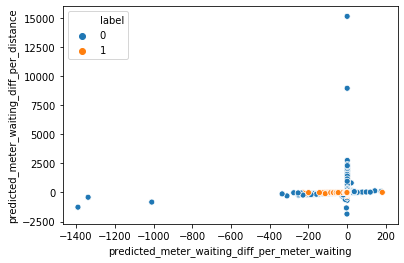

In [247]:
sns.scatterplot(x='predicted_meter_waiting_diff_per_meter_waiting',y='predicted_meter_waiting_diff_per_distance',data=train_df,hue='label')

In [248]:
train_df['predicted_meter_waiting_diff_per_meter_waiting@predicted_meter_waiting_diff_per_distance'] = train_df['predicted_meter_waiting_diff_per_meter_waiting'] * train_df['predicted_meter_waiting_diff_per_distance']
test_df['predicted_meter_waiting_diff_per_meter_waiting@predicted_meter_waiting_diff_per_distance'] = test_df['predicted_meter_waiting_diff_per_meter_waiting'] * test_df['predicted_meter_waiting_diff_per_distance']

In [249]:
train_df[train_df['label'] == 0]['predicted_meter_waiting_diff_per_meter_waiting@predicted_meter_waiting_diff_per_distance'].describe()

count    1.526000e+03
mean     2.852287e+03
std      5.202999e+04
min      1.007508e-05
25%      2.192696e+00
50%      1.339068e+01
75%      7.171228e+01
max      1.761322e+06
Name: predicted_meter_waiting_diff_per_meter_waiting@predicted_meter_waiting_diff_per_distance, dtype: float64

In [250]:
train_df[train_df['label'] == 1]['predicted_meter_waiting_diff_per_meter_waiting@predicted_meter_waiting_diff_per_distance'].describe()

count    1.544100e+04
mean     3.078298e+01
std      2.285285e+02
min      1.118093e-07
25%      1.376726e+00
50%      4.775182e+00
75%      1.570738e+01
max      1.948062e+04
Name: predicted_meter_waiting_diff_per_meter_waiting@predicted_meter_waiting_diff_per_distance, dtype: float64

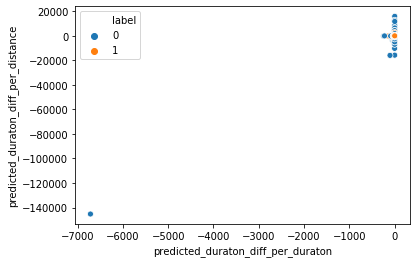

In [185]:
sns.scatterplot(x='predicted_duraton_diff_per_duraton',y='predicted_duraton_diff_per_distance',data=train_df,hue='label')

In [186]:
train_df['predicted_duraton_diff_per_duraton@predicted_duraton_diff_per_distance'] = train_df['predicted_duraton_diff_per_duraton'] * train_df['predicted_duraton_diff_per_distance']
test_df['predicted_duraton_diff_per_duraton@predicted_duraton_diff_per_distance'] = test_df['predicted_duraton_diff_per_duraton'] * test_df['predicted_duraton_diff_per_distance']

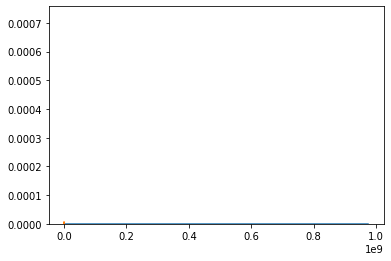

In [187]:
sns.distplot(train_df[train_df['label'] == 0]['predicted_duraton_diff_per_duraton@predicted_duraton_diff_per_distance'].values)
sns.distplot(train_df[train_df['label'] == 1]['predicted_duraton_diff_per_duraton@predicted_duraton_diff_per_distance'].values)

In [188]:
train_df[train_df['label'] == 0]['predicted_duraton_diff_per_duraton@predicted_duraton_diff_per_distance'].describe()

count    1.526000e+03
mean     6.420378e+05
std      2.497136e+07
min      4.143001e-04
25%      2.637187e+01
50%      1.992706e+02
75%      8.253681e+02
max      9.754840e+08
Name: predicted_duraton_diff_per_duraton@predicted_duraton_diff_per_distance, dtype: float64

In [189]:
train_df[train_df['label'] == 1]['predicted_duraton_diff_per_duraton@predicted_duraton_diff_per_distance'].describe()

count    1.544100e+04
mean     6.579070e+01
std      7.304414e+02
min      2.037052e-07
25%      1.141372e+00
50%      5.280961e+00
75%      1.754814e+01
max      6.855458e+04
Name: predicted_duraton_diff_per_duraton@predicted_duraton_diff_per_distance, dtype: float64

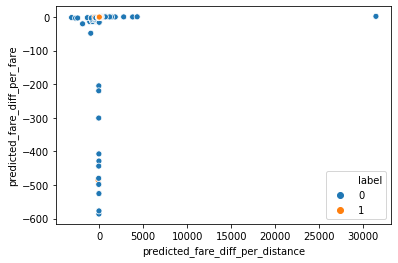

In [151]:
sns.scatterplot(x='predicted_fare_diff_per_distance',y='predicted_fare_diff_per_fare',data=train_df,hue='label')

In [153]:
train_df['predicted_fare_diff_per_distance@predicted_fare_diff_per_fare'] = train_df['predicted_fare_diff_per_distance'] * train_df['predicted_fare_diff_per_fare']
test_df['predicted_fare_diff_per_distance@predicted_fare_diff_per_fare'] = test_df['predicted_fare_diff_per_distance'] * test_df['predicted_fare_diff_per_fare']

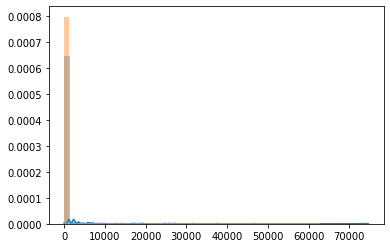

In [157]:
sns.distplot(train_df[train_df['label'] == 0]['predicted_fare_diff_per_distance@predicted_fare_diff_per_fare'].values)
sns.distplot(train_df[train_df['label'] == 1]['predicted_fare_diff_per_distance@predicted_fare_diff_per_fare'].values)

In [158]:
train_df[train_df['label'] == 1]['predicted_fare_diff_per_distance@predicted_fare_diff_per_fare'].describe()

count    1.544100e+04
mean     8.638190e+00
std      5.045815e+02
min      4.641873e-08
25%      2.488325e-01
50%      1.123370e+00
75%      3.514878e+00
max      6.259226e+04
Name: predicted_fare_diff_per_distance@predicted_fare_diff_per_fare, dtype: float64

In [159]:
train_df[train_df['label'] == 0]['predicted_fare_diff_per_distance@predicted_fare_diff_per_fare'].describe()

count    1.526000e+03
mean     4.408247e+02
std      3.112717e+03
min      3.948500e-08
25%      4.512736e+00
50%      2.502149e+01
75%      7.780106e+01
max      7.467344e+04
Name: predicted_fare_diff_per_distance@predicted_fare_diff_per_fare, dtype: float64

In [251]:
train_df.to_csv('train_df_final.csv',index=False)
test_df.to_csv('test_df_final.csv',index=False)

# Classifier

In [270]:
train_df = pd.read_csv('train_df_final.csv')
test_df = pd.read_csv('test_df_final.csv')

features = [
#     'additional_fare', 
#     'pickup_date', 
#     'pickup_hour',
#     'pickup_minute', 
#     'drop_date', 
#     'drop_hour', 
#     'drop_minute',    
#     'pick_cluster', 
#     'is_more_than_one_day', 
#     'distance_km', 
#     'pickup_timeslot', 
#     'day_of_week', 
#     'is_weekday', 
#     'cal_time_difference',
    # noise columns    
    'meter_waiting', 
    'meter_waiting_fare',
    'fare',
    'predicted_fare',
    'predicted_fare_diff',
    'predicted_fare_diff_per_fare',
    'predicted_fare_diff_per_predicted_fare', 
    'fare_per_distance',
    'predicted_fare_per_distance', 
    'predicted_fare_diff_per_distance',
    'predicted_duration',
    'predicted_duration_diff', 
    'predicted_duraton_diff_per_duraton',
    'predicted_duraton_diff_per_predicted_duration', 
    'fare_per_duration',
    'predicted_fare_per_duration', 
    'predicted_fare_per_duration_diff',
    'avg_speed', 
    'predicted_avg_speed', 
    'predicted_avg_speed_diff',
    'predicted_meter_waiting', 
    'predicted_meter_waiting_diff',
    'predicted_meter_waiting_diff_per_meter_waiting',
    'predicted_meter_waiting_diff_per_predicted_meter_waiting',
    'meter_waiting_per_duration', 
    'predicted_meter_waiting_per_duration',
    'predicted_meter_waiting_per_duration_diff',
    'predicted_meter_waiting_fare', 
    'predicted_meter_waiting_fare_diff',
    'predicted_meter_waiting_fare_diff_per_meter_waiting_fare',
    'predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare',
    'meter_waiting_fare_per_meter_waiting',
    'predicted_meter_waiting_fare_per_meter_waiting',
    'predicted_meter_waiting_fare_per_meter_waiting_diff',
    'meter_waiting_fare_per_duration',
    'predicted_meter_waiting_fare_per_duration',
    'predicted_meter_waiting_fare_per_duration_diff',
    'predicted_additional_fare', 
    'predicted_additional_fare_diff',
    'predicted_additional_fare_diff_per_additional_fare',
    'predicted_addtional_fare_per_fare', 
    'addtional_fare_per_fare',
    'addtional_fare_per_distance', 
    'predicted_addtional_fare_per_distance',
    'addtional_fare_per_duration', 
    'predicted_addtional_fare_per_duration',
    
#     'meter_waiting_till_pickup',
#     'predicted_meter_waiting_till_pickup',
#     'predicted_meter_waiting_till_pickup_diff',
    
#     'predicted_meter_waiting_till_pickup_diff_per_meter_waiting_till_pickup',
    
#     'meter_waiting_till_pickup_per_meter_waiting',
#     'predicted_meter_waiting_till_pickup_per_meter_waiting',
#     'predicted_meter_waiting_till_pickup_per_meter_waiting_diff',
    
#     'meter_waiting_after_pickup',
#     'predicted_meter_waiting_after_pickup',
    
#     'meter_waiting_till_pickup_per_duration',
#     'predicted_meter_waiting_till_pickup_per_duration',
    
#     'meter_waiting_after_pickup_per_duration',
#     'predicted_meter_waiting_after_pickup_per_duration',
    
#     'meter_waiting_till_pickup_per_distance',
#     'predicted_meter_waiting_till_pickup_per_distance',
    
#     'meter_waiting_after_pickup_per_distance',
#     'predicted_meter_waiting_after_pickup_per_distance',
    
#     'meter_waiting_till_pickup_per_fare',
#     'predicted_meter_waiting_till_pickup_per_fare',
    
#     'meter_waiting_after_pickup_per_fare',
#     'predicted_meter_waiting_after_pickup_per_fare', 
    
#     'fare-additional_fare',
#     'predicted_fare-additional_fare',
    
#     'fare-additional_fare-meter_waiting_fare',
#     'predicted_fare-additional_fare-meter_waiting_fare',
    
#     'meter_waiting_till_pickup_per_meter_waiting_fare',
#     'predicted_meter_waiting_till_pickup_per_meter_waiting_fare',
    
#     'meter_waiting_after_pickup_per_meter_waiting_fare',
#     'predicted_meter_waiting_after_pickup_per_meter_waiting_fare',
    
#     'fare-additional_fare-meter_waiting_fare_per_distance',
#     'predicted_fare-additional_fare-meter_waiting_fare_per_distance',
    
#     'fare-additional_fare-meter_waiting_fare_per_duration',
#     'predicted_fare-additional_fare-meter_waiting_fare_per_duration',
    
#     'fare-additional_fare_per_distance',
#     'predicted_fare-additional_fare_per_distance',
    
#     'fare-additional_fare_per_duration',
#     'predicted_fare-additional_fare_per_duration',
    
#     'additional_fare_anomaly', 
#     'duration_anomaly', 
#     'meter_waiting_anomaly',
#     'meter_waiting_fare_anomaly',
#     'meter_waiting_till_pickup_anomaly',
#     'additional_fare_duration_anomaly',
#     'additional_fare_meter_waiting_anomaly',
#     'additional_fare_meter_waiting_fare_anomaly',
#     'additional_fare_meter_waiting_till_pickup_anomaly',
#     'duration_meter_waiting_anomaly', 
#     'duration_meter_waiting_fare_anomaly',
#     'duration_meter_waiting_till_pickup_anomaly',
#     'meter_waiting_meter_waiting_fare_anomaly',
#     'meter_waiting_meter_waiting_till_pickup_anomaly',
#     'meter_waiting_fare_meter_waiting_till_pickup_anomaly',
#     'additional_fare_duration_meter_waiting_anomaly',
#     'additional_fare_duration_meter_waiting_fare_anomaly',
#     'additional_fare_duration_meter_waiting_till_pickup_anomaly',
#     'additional_fare_meter_waiting_meter_waiting_fare_anomaly',
#     'additional_fare_meter_waiting_meter_waiting_till_pickup_anomaly',
#     'additional_fare_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
#     'duration_meter_waiting_meter_waiting_fare_anomaly',
#     'duration_meter_waiting_meter_waiting_till_pickup_anomaly',
#     'duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
#     'meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
#     'additional_fare_duration_meter_waiting_meter_waiting_fare_anomaly',
#     'additional_fare_duration_meter_waiting_meter_waiting_till_pickup_anomaly',
#     'additional_fare_duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
#     'additional_fare_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
#     'duration_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
#     'additional_fare_duration_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly'
    
#     'fare_anomaly_predicted_fare_diff_prod',
# #     'fare_anomaly_predicted_fare_diff_per_fare_prod',
#     'fare_anomaly_predicted_fare_diff_per_distance_prod',
#     'additional_fare_anomaly_predicted_additional_fare_diff_prod',
# #     'additional_fare_anomaly_predicted_additional_fare_diff_per_additional_fare_prod',
#     'additional_fare_anomaly_predicted_addtional_fare_per_distance_prod',
#     'duration_anomaly_predicted_duration_diff_prod',
# #     'duration_anomaly_predicted_duraton_diff_per_duraton_prod',
#     'duration_anomaly_predicted_duraton_diff_per_distance_prod',
#     'meter_waiting_anomaly_predicted_meter_waiting_diff_prod',
# #     'meter_waiting_anomaly_predicted_meter_waiting_diff_per_meter_waiting_prod',
#     'meter_waiting_anomaly_predicted_meter_waiting_diff_per_distance_prod',
#     'meter_waiting_fare_anomaly_predicted_meter_waiting_fare_diff_prod',
# #     'meter_waiting_fare_anomaly_predicted_meter_waiting_fare_diff_per_meter_waiting_fare_prod',
#     'meter_waiting_fare_anomaly_predicted_meter_waiting_fare_diff_per_distance_prod'
    
#     'predicted_fare_diff_per_distance@predicted_fare_diff_per_fare',
    'predicted_duraton_diff_per_duraton@predicted_duraton_diff_per_distance',
#     'predicted_meter_waiting_diff_per_meter_waiting@predicted_meter_waiting_diff_per_distance'
]

In [271]:
cat_features = [
#     'pickup_date', 
#     'pickup_hour',
#     'pickup_minute', 
#     'drop_date', 
#     'drop_hour', 
#     'drop_minute',    
#     'pick_cluster', 
#     'is_more_than_one_day', 
#     'pickup_timeslot', 
#     'day_of_week', 
#     'is_weekday', 
    
#     'additional_fare_anomaly', 
#     'duration_anomaly', 
#     'meter_waiting_anomaly',
#     'meter_waiting_fare_anomaly',
#     'meter_waiting_till_pickup_anomaly',
#     'additional_fare_duration_anomaly',
#     'additional_fare_meter_waiting_anomaly',
#     'additional_fare_meter_waiting_fare_anomaly',
#     'additional_fare_meter_waiting_till_pickup_anomaly',
#     'duration_meter_waiting_anomaly', 
#     'duration_meter_waiting_fare_anomaly',
#     'duration_meter_waiting_till_pickup_anomaly',
#     'meter_waiting_meter_waiting_fare_anomaly',
#     'meter_waiting_meter_waiting_till_pickup_anomaly',
#     'meter_waiting_fare_meter_waiting_till_pickup_anomaly',
#     'additional_fare_duration_meter_waiting_anomaly',
#     'additional_fare_duration_meter_waiting_fare_anomaly',
#     'additional_fare_duration_meter_waiting_till_pickup_anomaly',
#     'additional_fare_meter_waiting_meter_waiting_fare_anomaly',
#     'additional_fare_meter_waiting_meter_waiting_till_pickup_anomaly',
#     'additional_fare_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
#     'duration_meter_waiting_meter_waiting_fare_anomaly',
#     'duration_meter_waiting_meter_waiting_till_pickup_anomaly',
#     'duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
#     'meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
#     'additional_fare_duration_meter_waiting_meter_waiting_fare_anomaly',
#     'additional_fare_duration_meter_waiting_meter_waiting_till_pickup_anomaly',
#     'additional_fare_duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
#     'additional_fare_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
#     'duration_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
#     'additional_fare_duration_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly'
]

In [272]:
labels = train_df['label'].values
train_df = train_df.drop(['label'], axis=1)[features]

In [273]:
class_weights = [(labels.shape[0] - np.sum(labels)) / np.sum(labels),1]

In [274]:
skf = StratifiedKFold(n_splits=3)

In [275]:
params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
#     'class_weights':class_weights,
    'border_count':512,
#     'depth':8
}

In [276]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)
train_df_pool = Pool(data=train_df[features], cat_features=cat_features)

In [277]:
validation_scores = []
submission_preds = np.zeros(submission_df.shape[0])
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_pools = []
models = []
for train_index, test_index in skf.split(train_df, labels):
    X_train, X_test = train_df.iloc[train_index,:], train_df.iloc[test_index,:]
    y_train, y_test = labels[train_index], labels[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    pred = model.predict(test_pool)
    validation_score = model.best_score_['validation']['F1']
    print('Validation f1',validation_score)
    validation_scores.append(validation_score)
    models.append(model)
    train_pools.append(train_pool)
    submission_preds += model.predict(submission_pool)
    train_preds += model.predict_proba(train_df_pool)[:,1]
    test_preds += model.predict_proba(submission_pool)[:,1]

Learning rate set to 0.057693
0:	learn: 0.9683860	test: 0.9710421	best: 0.9710421 (0)	total: 24ms	remaining: 23.9s
10:	learn: 0.9738035	test: 0.9776034	best: 0.9776034 (10)	total: 245ms	remaining: 22.1s
20:	learn: 0.9750669	test: 0.9777735	best: 0.9779693 (19)	total: 467ms	remaining: 21.8s
30:	learn: 0.9765348	test: 0.9788827	best: 0.9790827 (27)	total: 740ms	remaining: 23.1s
40:	learn: 0.9776606	test: 0.9787806	best: 0.9790827 (27)	total: 905ms	remaining: 21.2s
50:	learn: 0.9780868	test: 0.9790546	best: 0.9791527 (46)	total: 1.08s	remaining: 20s
60:	learn: 0.9786499	test: 0.9788624	best: 0.9791527 (46)	total: 1.32s	remaining: 20.3s
70:	learn: 0.9789337	test: 0.9790425	best: 0.9791527 (46)	total: 1.58s	remaining: 20.7s
80:	learn: 0.9796487	test: 0.9794231	best: 0.9795212 (77)	total: 1.83s	remaining: 20.8s
90:	learn: 0.9800269	test: 0.9793210	best: 0.9796154 (85)	total: 2.02s	remaining: 20.1s
100:	learn: 0.9807877	test: 0.9793210	best: 0.9796154 (85)	total: 2.19s	remaining: 19.5s
110:	l

In [278]:
np.mean(validation_scores), np.std(validation_scores)

(0.9772052035774527, 0.0029710466839847635)

In [279]:
submission_df['prediction'] = np.where(submission_preds > 2, 1, 0)
submission_df.to_csv('submission.csv',index=False)

In [280]:
best_model = models[np.argmax(validation_scores)]

In [281]:
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,fare_per_distance,10.923818
1,predicted_duration_diff,8.185030
2,predicted_fare_diff_per_distance,6.296288
3,predicted_duraton_diff_per_duraton@predicted_d...,5.680319
4,predicted_fare_diff_per_fare,5.080803
5,predicted_additional_fare_diff_per_additional_...,4.543071
6,avg_speed,3.880585
7,predicted_avg_speed,3.741070
8,predicted_additional_fare_diff,3.738512
9,predicted_fare_diff,3.350844


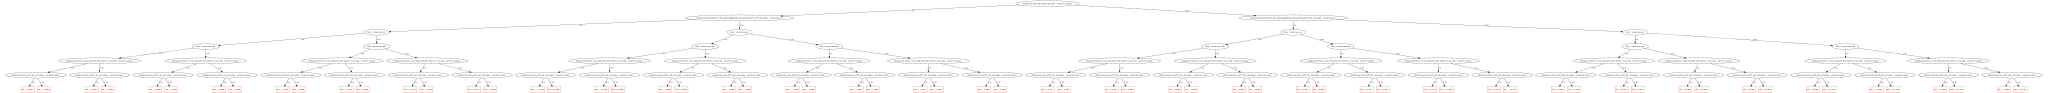

In [282]:
best_model.plot_tree(0,train_pools[np.argmax(validation_scores)])

In [283]:
worst_model = models[np.argmin(validation_scores)]

In [284]:
worst_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,predicted_duraton_diff_per_duraton@predicted_d...,8.946430
1,predicted_duration_diff,8.341656
2,fare_per_distance,8.007227
3,predicted_fare_diff_per_fare,6.775459
4,predicted_fare_diff_per_distance,6.213236
5,predicted_additional_fare_diff_per_additional_...,4.648968
6,fare_per_duration,3.631689
7,predicted_fare_diff,3.380814
8,predicted_addtional_fare_per_distance,2.620580
9,predicted_fare_diff_per_predicted_fare,2.531481


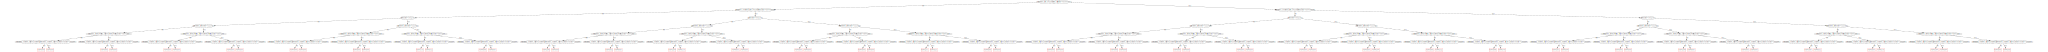

In [285]:
worst_model.plot_tree(0,train_pools[np.argmax(validation_scores)])

In [286]:
cv_params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
    'verbose': False
}

In [ ]:
cv_pool = Pool(data=train_df,label=labels)

In [ ]:
scores = cv(cv_pool,cv_params,plot=True, fold_count=3)

In [ ]:
def filter_features(features):
    features_to_drop = []
    features_to_keep = []
    for feature in features:
        if feature in features_to_drop:
            continue
        highly_corr_features = list((np.array(features))[np.abs(train_df[features].corr()[feature]) > 0.8])
        for each in highly_corr_features:
            if each == feature or each in features_to_keep:
                continue
            else:
                features_to_drop.append(each)
        features_to_keep.append(feature)
    return features_to_keep

In [ ]:
f = list(best_model.get_feature_importance(prettified=True)['Feature Id'].values)
new_features = filter_features(f)

In [ ]:
sns.heatmap(train_df[new_features].corr())

In [ ]:
train_df = train_df[new_features]

In [ ]:
submission_pool = Pool(data=test_df[new_features])

In [ ]:
validation_scores = []
submission_preds = np.zeros(submission_df.shape[0])
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_pools = []
models = []
for train_index, test_index in skf.split(train_df, labels):
    X_train, X_test = train_df.iloc[train_index,:], train_df.iloc[test_index,:]
    y_train, y_test = labels[train_index], labels[test_index]
    train_pool = Pool(data=X_train, label=y_train)
    test_pool = Pool(data=X_test, label=y_test)    
    model = CatBoostClassifier(**params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    pred = model.predict(test_pool)
    validation_score = model.best_score_['validation']['F1']
    print('Validation f1',validation_score)
    validation_scores.append(validation_score)
    models.append(model)
    train_pools.append(train_pool)
    submission_preds += model.predict(submission_pool)
    train_preds += model.predict_proba(train_df_pool)[:,1]
    test_preds += model.predict_proba(submission_pool)[:,1]

In [ ]:
np.mean(validation_scores), np.std(validation_scores)

In [ ]:
stacking_train_df['catboost_low_corr'] = train_preds

stacking_test_df['catboost_low_corr'] = submission_preds

In [ ]:
stacking_train_df.to_csv('stacking_train_df.csv',index=False)
stacking_test_df.to_csv('stacking_test_df.csv',index=False)

In [ ]:
submission_df['prediction'] = np.where(submission_preds > 2, 1, 0)
submission_df.to_csv('submission_filtered.csv',index=False)

In [ ]:
best_model = models[np.argmax(validation_scores)]

In [ ]:
best_model.get_feature_importance(prettified=True)

In [ ]:
best_model.plot_tree(0,train_pools[np.argmax(validation_scores)])

In [ ]:
cv_pool = Pool(data=train_df,label=labels)

In [ ]:
scores = cv(cv_pool,cv_params,plot=True, fold_count=3)